In [0]:
import shutil
import os
import datetime
import sys 
 

In [0]:
 
dfPacientes = spark.read.format("csv").option("header", "true").option("delimiter", "|").load("dbfs:/FileStore/mnt/cargas/stage/EINSTEIN_Pacientes_2.csv")

dfExames = spark.read.format("csv").option("header", "true").option("delimiter", "|").load("dbfs:/FileStore/mnt/cargas/stage/EINSTEIN_Exames_2.csv") 
 

In [0]:
from pyspark.sql.functions import current_date
 
dfExamesRaw = dfExames.withColumn("DT_CARGA", current_date() ) 
dfExamesRaw.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/raw/dfExames.parquet")

dfPacientesRaw = dfPacientes.withColumn("DT_CARGA", current_date() ) 
dfPacientesRaw.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/raw/dfPacientes.parquet")
 

In [0]:
#now = datetime.datetime.now()
#date_str = now.strftime("%Y-%m-%d") 
#dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/stage/historico/" + date_str + "/")  
#for file in os.listdir("/dbfs/FileStore/mnt/cargas/stage/"):
#    if file.endswith(".csv"):
#        shutil.move(os.path.join("/dbfs/FileStore/mnt/cargas/stage/", file), os.path.join(f"/dbfs/FileStore/mnt/cargas/#stage/historico/{date_str}", file))

In [0]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col 

dfPacientesRaw = dfPacientesRaw.withColumn("CD_MUNICIPIO", regexp_replace("CD_MUNICIPIO", "MMMM", "HIDEN")) 
dfPacientesRaw = dfPacientesRaw.withColumn("CD_MUNICIPIO", regexp_replace("CD_CEPREDUZIDO", "CCCC", "HIDEN")) 


In [0]:

dfPacientesHot = dfPacientesRaw.filter(col("ID_PACIENTE").isNotNull() & col("AA_NASCIMENTO").isNotNull() & col("CD_PAIS").isNotNull() & col("CD_MUNICIPIO").isNotNull())

dfPacientesRejected = dfPacientesRaw.filter(col("ID_PACIENTE").isNull() | col("AA_NASCIMENTO").isNull() | col("CD_PAIS").isNull() | col("CD_MUNICIPIO").isNull())

dfPacientesHot.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/curated/hot/dfPacientes.parquet")

dfPacientesRejected.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/curated/rejected/dfPacientes.parquet")


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import to_date

def limpaResultado(resultado):
    return " ".join(resultado.lower().split())

#dfEraw = dfE.withColumn("DT_CARGA", current_date()) 

limpaResultado_udf = udf(limpaResultado, StringType())  
dfExamesRaw = dfExamesRaw.withColumn("DT_COLETA", to_date(col("DT_COLETA"), 'dd/MM/yyyy')) 
dfExamesRaw = dfExamesRaw.withColumn("DE_RESULTADO", limpaResultado_udf("DE_RESULTADO"))

dfExamesHot = dfExamesRaw.filter(col("ID_PACIENTE").isNotNull() & col("DT_COLETA").isNotNull() & col("DE_ORIGEM").isNotNull() & col("DE_EXAME").isNotNull() & col("DE_RESULTADO").isNotNull())

dfExamesRejected = dfExamesRaw.filter(col("ID_PACIENTE").isNull() | col("DT_COLETA").isNull() | col("DE_ORIGEM").isNull() | col("DE_EXAME").isNull() | col("DE_RESULTADO").isNull()) 

dfExamesHot.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/curated/hot/dfExames.parquet")

dfExamesRejected.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/curated/rejected/dfExames.parquet")

In [0]:
spark.sql("CREATE OR REPLACE TEMPORARY VIEW Exames USING parquet OPTIONS (path \'dbfs:/FileStore/mnt/cargas/curated/hot/dfExames.parquet')")

Out[88]: DataFrame[]

In [0]:
spark.sql("CREATE OR REPLACE TEMPORARY VIEW Pacientes USING parquet OPTIONS (path \'dbfs:/FileStore/mnt/cargas/curated/hot/dfPacientes.parquet')")

Out[89]: DataFrame[]

In [0]:
dfContagem_exames_por_pacientes = spark.sql("SELECT p.id_paciente, count(*) ContagemExames FROM Exames e inner join Pacientes p on e.id_paciente = p.id_paciente GROUP BY p.id_paciente ") 

dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/service/contagem_exames_por_pacientes")

dfExamesRejected.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/service/contagem_exames_por_pacientes/dfContagemExamesPorPaciente.parquet")

dbutils.fs.ls("dbfs:/FileStore/mnt/cargas/service/contagem_exames_por_pacientes")

Out[90]: [FileInfo(path='dbfs:/FileStore/mnt/cargas/service/contagem_exames_por_pacientes/dfContagemExamesPorPaciente.parquet/', name='dfContagemExamesPorPaciente.parquet/', size=0, modificationTime=1685474351000)]

In [0]:
dfExamesPorPacientes  = spark.sql("SELECT round(datediff(current_date() , to_date(CONCAT(AA_NASCIMENTO ,'-01-01')))/ 365.25,0) VL_IDADE, p.ID_PACIENTE, p.IC_SEXO, p.CD_UF, p.CD_MUNICIPIO, p.CD_CEPREDUZIDO, p.CD_PAIS  ,  \
          \
          e.DT_COLETA, e.DE_ORIGEM, e.DE_EXAME, e.DE_ANALITO, e.DE_RESULTADO, e.CD_UNIDADE, e.DE_VALOR_REFERENCIA  \
           FROM Exames e inner join Pacientes p on e.id_paciente = p.id_paciente")

#dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/service/exames_por_pacientes") 
dfExamesPorPacientes.write.partitionBy('CD_UF', 'CD_PAIS').format("parquet").option("compression", "snappy").\
option("encoding", "UTF-8").mode("overwrite").\
parquet("dbfs:/FileStore/mnt/cargas/service/exames_por_pacientes/dfExamesPorPaciente.parquet")


In [0]:
 
dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/service/exames_por_pacientes_sp") 
 
#inverti o particionamento pq não uso o cd_pais na consulta
dfExamesPacienteSP = dfExamesPorPacientes.filter(col("CD_UF") == "SP")
dfExamesPacienteSP.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").parquet("dbfs:/FileStore/mnt/cargas/service/exames_por_pacientes_sp/dfExamesPorPacienteSP.parquet")


In [0]:
import pandas as pd
from pyspark.sql import SparkSession
# Read in data
dfExamesPacienteSP_pandas = dfExamesPacienteSP.toPandas() 
dfExamesPacienteSP_pandas_ResultadoNaoNumerico = dfExamesPacienteSP_pandas[dfExamesPacienteSP_pandas['DE_RESULTADO'].apply(lambda x: not x.isnumeric())]
 

/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [VL_IDADE] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


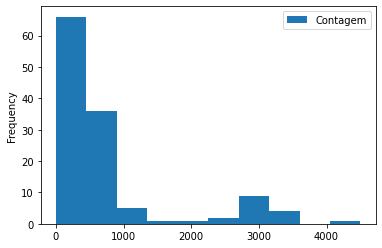

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
 
contagem = dfExamesPacienteSP_pandas_ResultadoNaoNumerico['DE_ANALITO'].value_counts() 
df_contagem = pd.DataFrame({'DE_ANALITO': contagem.index, 'Contagem': contagem.values})
 
df_contagem.plot.hist(x='DE_ANALITO', y='Contagem', bins=10)

plt.show()
 


In [0]:
dfContagemExamesResultadoNaoNumerico = spark.sql("SELECT  e.DE_EXAME, e.DE_ANALITO, count(*) CONTAGEM\
           FROM Exames e inner join Pacientes p on e.id_paciente = p.id_paciente\
           where e.DE_RESULTADO RLIKE '^[0-9]*$'\
           GROUP BY e.DE_EXAME, e.DE_ANALITO")

display(dfContagemExamesResultadoNaoNumerico)


DE_EXAME,DE_ANALITO,CONTAGEM
Contagem de Plaquetas,Plaquetas,108
Dosagem de Gama GT,Gama GT,1234
Gasometria Arterial,pO2 (gasometria arterial),1
Gasometria Venosa,Fio2 (gasometria venosa),471
TTPA,TTPA segundos,1
Diferencial Manual,Basófilos #,637
Diferencial Manual,Promielócitos #,636
Leucograma Auto,Eosinófilos #,1
Urina Tipo I,pH,42
Dosagem de Lipase,Dosagem de Lipase,506


In [0]:
dfContagemExamesResultadoNaoNumerico = dfContagemExamesResultadoNaoNumerico.toPandas()


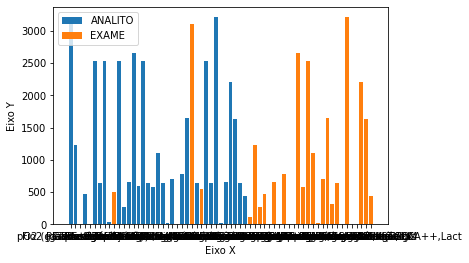

In [0]:


fig, ax = plt.subplots()
ax.bar(dfContagemExamesResultadoNaoNumerico['DE_ANALITO'], dfContagemExamesResultadoNaoNumerico['CONTAGEM'], label="ANALITO")
ax.bar(dfContagemExamesResultadoNaoNumerico['DE_EXAME'], dfContagemExamesResultadoNaoNumerico['CONTAGEM'], label="EXAME" )
ax.set_xlabel("Eixo X")
ax.set_ylabel("Eixo Y")
ax.legend()

# exibir gráfico resultante
plt.show()


In [0]:
 #dfContagem_exames_por_pacientes = spark.sql("SELECT p.id_paciente, count(*) ContagemExames FROM Exames e inner join #Pacientes p on e.id_paciente = p.id_paciente GROUP BY p.id_paciente ") 

#dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/service/exames_por_pacientes")

#dfExamesRejected.write.format("parquet").option("compression", "snappy").option("encoding", "UTF-8").mode("overwrite").#parquet("dbfs:/FileStore/mnt/cargas/service/exames_por_pacientes/dfExamesPorPaciente.parquet")

#dbutils.fs.ls("dbfs:/FileStore/mnt/cargas/service/exames_por_pacientes")

In [0]:
#criar estrutura de pastas 
#dbutils.fs.ls("dbfs:/FileStore/mnt/cargas/stage/hi")
#dbutils.fs.ls("dbfs:/FileStore/mnt/cargas/stage/historico/2023-05-29/")
#dbutils.fs.ls("dbfs:/FileStore/mnt/cargas/curated/hot")
#dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/curated/")
#dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/curated/hot")
#dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/curated/rejected")
#dbutils.fs.mkdirs("dbfs:/FileStore/mnt/cargas/service/")
#dbutils.fs.mkdirs("dbfs:/FileStore/shared_uploads/elcides.marques.filho@hotmail.com/EINSTEIN_Exames_2.csv")
#dbutils.fs.rm("dbfs:/FileStore/shared_uploads/elcides.marques.filho@hotmail.com/EINSTEIN_Pacientes_2.csv")